In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))
print_tensor = lambda n, x: print(n, type(x), x.shape, x.min(), x.max())
print(sys.path)
# from pathlib import Pathth


['/home/dejuns/git/mmdet4med/demo', '/home/dejuns/git/nnDetection', '/home/dejuns/git/MONAI', '/home/dejuns/git/mmdet4med/demo', '/home/dejuns/miniconda3/lib/python38.zip', '/home/dejuns/miniconda3/lib/python3.8', '/home/dejuns/miniconda3/lib/python3.8/lib-dynload', '', '/home/dejuns/miniconda3/lib/python3.8/site-packages', '/home/dejuns/git/mmseg4med', '/home/dejuns/miniconda3/lib/python3.8/site-packages/D3D-1.0-py3.8-linux-x86_64.egg', '/home/dejuns/miniconda3/lib/python3.8/site-packages/IPython/extensions', '/home/dejuns/.ipython', '/home/dejuns/git/mmdet4med']


In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
from demo.visual_gt_pred import *
import re
import mmcv

# # load data from a file-like object, supporting json, yaml and pickle.
# with open('test.json', 'r') as f:
#     data = mmcv.load(f, file_format='json')
# # dump data to a string
# json_str = mmcv.dump(data, file_format='json')
# mmcv.list_from_file('a.txt')

In [4]:
# tb_rt = Path('/data/lung_algorithm/data/DetFrac/processed_new/plan_rib_crop')
tb_rt = Path('/mnt/data4t/dejuns/ribfrac/processed/plan_frac_recheck')

cohortids = [a for a in os.listdir(tb_rt) if os.path.isdir(tb_rt/a)]

roi_all_list = []
for cohort in cohortids:
    cohort_dir = tb_rt/cohort
    cids = os.listdir(cohort_dir)
    
    for cid in cids:
        roi_fp = cohort_dir/f'{cid}/{cid}_ins2cls.json'
        with open(roi_fp, 'r') as f:
            roi_info = mmcv.load(f, file_format='json')
        for roi in roi_info: 
            roi['cohort'] = cohort
            roi['cid'] = cid
            roi['size'] = np.linalg.norm(np.array(roi['bbox'])[3:] - np.array(roi['bbox'])[:3])
        roi_all_list.extend(roi_info)

roi_all_tb = pd.DataFrame(roi_all_list)
roi_all_tb['source'] = roi_all_tb['cohort'].apply(lambda x: 'ky' if 'KY' in x else 'pub')
roi_all_tb.info()
roi_all_tb.to_csv(tb_rt/'fracture_instance_info_all.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6986 entries, 0 to 6985
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   bbox      6986 non-null   object 
 1   center    6986 non-null   object 
 2   class     6986 non-null   int64  
 3   instance  6986 non-null   int64  
 4   cohort    6986 non-null   object 
 5   cid       6986 non-null   object 
 6   size      6986 non-null   float64
 7   source    6986 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 436.8+ KB


In [7]:
class_unique = roi_all_tb['class'].unique()
print(class_unique)

error_cls_mask = roi_all_tb['class'] > 5
error_cls_tb = roi_all_tb.loc[error_cls_mask , : ]
# error_cls_mask.to_csv(tb_rt/'fracture_instance_error_cls_mask.csv')
num_of_error = sum(error_cls_mask)
error_pids = error_cls_tb['cid'].unique()
print(f'class 7 instance {num_of_error} pid', len(error_pids))
aa = [print(a) for a in error_pids]

[5 2 3 4 1 7]
class 7 instance 37 pid 24
1603363-20200730
1601292-20200727
1623917-20200830
1675698-20201113
1661049-20201023
1668356-20201103
1677784-20201117
3807983
3025737
3807050
1674132-20201111
1731070_20210204
1729893_20210202
2074331
1398111_20190725
1672012-20201108
1647463-20201002
1666875-20201101
1667050-20201101
1672258-20201109
1646995-20201001
1617405-20200820
1616225-20200819
1617669-20200820


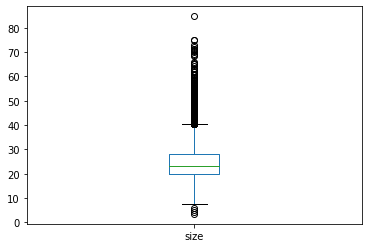

In [8]:
# roi_all_tb['size'].hist(bins = 40, by= roi_all_tb['class'], layout = (1, 4), figsize=(12, 3))
ax = roi_all_tb['size'].plot.box(by= roi_all_tb['class'])


<AxesSubplot:>

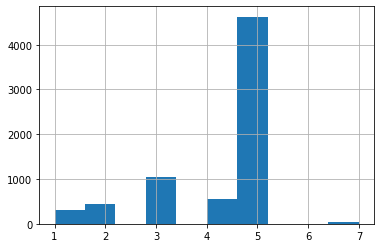

In [9]:

roi_all_tb['class'].hist() # by= roi_all_tb['source']


In [10]:
cls_by_source = pd.crosstab(roi_all_tb['class'], roi_all_tb['source'])
print(cls_by_source)

source    ky
class       
1        305
2        442
3       1035
4        543
5       4624
7         37


In [ ]:
roi_info_ky = roi_all_tb.loc[roi_all_tb['source'] == 'ky', :]
# roi_info_pub = roi_all_tb.loc[roi_all_tb['source'] == 'pub', :]

roi_info_ky['size'].hist(by= roi_info_ky['class'], layout = (1, 6), figsize=(12, 3))
# roi_info_pub['size'].hist(by= roi_info_pub['class'], layout = (1, 4), figsize=(12, 3))

print('Num fracture keya', len(roi_info_ky))
# print('Num fracture pub', len(roi_info_pub))

In [ ]:
tp_mask = roi_all_tb.loc[roi_all_tb['class'] < 5 , : ]
roi_tp_tb = roi_all_tb.loc[tp_mask, :]
roi_tp_tb.reset_index(inpl)
pid_base_infos = pd.pivot_table(roi_tp_tb, index = ['cid', 'cohort', 'source'], values = 'instance', aggfunc=lambda x: len(x))
pid_base_infos.reset_index(inplace = True)
print(pid_base_infos.info())
print(pid_base_infos.describe())
# pred_case_tb = pd.pivot_table(pred_nodes_tb,index = ['pid', 'date_num', 'sub_dir'],
#                                           # columns = [''],
#                                           values = 'node_type',
#                                           aggfunc=lambda x:len(x))

In [ ]:
pid_base_infos['instance'].hist(by = pid_base_infos['source'])

In [ ]:
# pib_ky_tb = pid_base_infos.loc[pid_base_infos['source'] == 'ky', :]
count_by_cohort = pid_base_infos['cohort'].value_counts()
print(count_by_cohort, sum(count_by_cohort))


In [ ]:
ax = count_by_cohort.plot.bar()
print(ax)